# Calculation of the deformation velocity 


In this notebook, we present explicit calculations with the deformation velocity $\mathbf{v}_d$ associated to a given velocity field $\mathbf{v}$. 

This is defined following a decomposition of the original velocity field into two components

$$
\begin{equation}
\label{eq1}
\mathbf{v} = \mathbf{v}_{RB} + \mathbf{v}_{d},
\end{equation}
$$

where $\mathbf{v}_{RB}$ is the rigid body-component of the velocity field and $\mathbf{v}_d$ comes from deformations. 
We propose three criteria for defining $\mathbf{v}_{RB}$

- It should be a rigid body velocity field that is closest to the original velocity field in a physically relevant norm.

- The deformation component, which we get by subtracting $\mathbf{v}_{RB}$ from the original velocity field should be objective (or frame indifferent) in order to capture
intrinsic features of the fluid (see Truesdell & Noll (2004)),

- The deformation component should be observable: an appropriately chosen, single observer of the fluid flow should be able to measure this deformation velocity field over the whole domain.


Our approach is based on looking for the $\mathbf{v}_{RB}$ as the $L^{2}$ closest velocity field to the input velocity field $\mathbf{v}$. Without loss of generality, the rigid-body velocity field $\mathbf{v}_{RB}$ can be written as 

$$
\begin{equation}
\label{eq2}
\mathbf{v}_{RB} = \bar{\mathbf{v}} + \boldsymbol{\omega} \times (\mathbf{x} - \bar{\mathbf{x}}),
\end{equation}
$$

where the overbar denotes spatial averaging over a chosen domain $U \in \mathbb{R}^{3}$. We then minimize the functional defined as 

$$
L_{1}(\boldsymbol{\Omega},t) = \frac{1}{M}\int_{U}\left\{ \left|\mathbf{v}(\mathbf{\mathbf{x}},t)-\dot{\mathbf{x}}_{A}(t)-\boldsymbol{\Omega}(t)\left(\mathbf{x}-\mathbf{x}_{A}(t)\right)\right|^{2}\right\}\rho(\mathbf{x},t)dV,
$$

where M is the total mass contained in the volume $U$ and $\rho(\mathbf{x},t)$ is the density.

A unique minimizing angular velocity exists and can be written as
$$
\boldsymbol{\omega}=M\boldsymbol{\Theta}^{-1}\overline{(\mathbf{x}-\bar{\mathbf{x}})\times(\mathbf{v}-\bar{\mathbf{v}})},
$$

with the moment of inertia tensor defined as 

$$
\boldsymbol{\Theta} = M\overline{\left(\left|\mathbf{x}-\bar{\mathbf{x}}\right|^{2}\right)\mathbf{I}-(\mathbf{x}-\bar{\mathbf{x}})\otimes(\mathbf{x}-\bar{\mathbf{x}})}.
$$

In the following sections, we calculate the minimizing $\boldsymbol{\omega}$ and through it, the deformation velocity $$
\begin{equation}
\label{eq3}
\mathbf{v}_d = \mathbf{v} - \bar{\mathbf{v}} - \boldsymbol{\omega} \times (\mathbf{x} - \bar{\mathbf{x}}).
\end{equation}
$$

As shown in Kaszás, Pedergnana, & Haller (2022), the deformation velocity field defined in (3) is objective. This means, that an observer in the rotating $\mathbf{y}-$ frame will measure the velocity to be 

$$
\hat{\mathbf{v}} = \mathbf{Q}^T(t)\mathbf{v},
$$

if the (stationary) $\mathbf{x}-$ and (rotating and translating) $\mathbf{y}-$ frames are related by

$$
\mathbf{x} = \mathbf{Q}(t)\mathbf{y} + \mathbf{b}(t).
$$

# Two-dimensional examples 

We first consider two-dimensional examples. Whenever the velocity fields are given in analytic form, we do the calculations symbolically with the help of ```SymPy```. 

The examples we consider are

- An explicit, polynomial solution to the Navier-Stokes equations

- Ocean surface velocity field in the Gulf Stream region

## Explicit NS solution

In [16]:
from sympy import latex
from IPython.display import display_latex

## The following helper function is used for displaying variables in latex form
def disp(idx, symObj):
    eqn = '\\[' + idx + ' = ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

In [17]:
import sympy as sy
import sympy.vector
R = sy.vector.CoordSys3D('R')

We first set up the symbolic variables and define the velocity field

In [28]:
x, y, z, t = sy.symbols('x,y,z,t')
alpha = sy.symbols('alpha')
h = sy.symbols('h')
a = sy.symbols('a', positive=True)

The domain of definition is assumed to be 
$$
U_a = [-a, a]\times [-a,a]
$$

In [29]:
velocityOriginal = (sy.sin(4*t)*R.x + (sy.cos(4*t)+2)*R.y+h*(R.x*(R.x**2-3*R.y**2)))*R.i + ((sy.cos(4*t)-2)*R.x-sy.sin(4*t)*R.y-h*(R.y*(3*R.x**2-R.y**2)))*R.j 
# define the input velocity
position = R.x*R.i + R.y*R.j+R.z*R.k # convert it to matrix form and switch to (x,y) coordinates
velocityOriginalMtx = velocityOriginal.to_matrix(R).subs([(R.x, x), (R.y, y)])
disp('\\mathbf{v}(x,y)',velocityOriginalMtx)



We need to calculate:

- The spatial average of $\mathbf{v}$ over $U_a$

- The moment of inertia tensor

- The optimal rigid-body angular velocity 



In [30]:
def average_overDomain2D(quantity, variables, domainX, domainY):
    #  function for averaging over planar and rectangular domains 
    xmin, xmax = domainX
    ymin, ymax = domainY
    domainSize = (xmax - xmin) * (ymax - ymin)
    x,y,z = variables
    # do the integration for each component
    return sy.Matrix([sy.integrate(quantity[i], (x, xmin, xmax), (y, ymin, ymax)).doit() / domainSize for i in range(len(quantity))])

In [31]:
def InertiaTensor(domainX, domainY):
    # need to formally calculate all moments of inertia, even though only the zz component will matter here.
    # we can use this function for both symbolic and numerical calculations later
    position = sy.Matrix([x,y,z])
    positionsq = x**2 + y**2 + z**2
    # calculate integration limits
    Xsize = domainX[1] - domainX[0] # total size of X domain
    xmin = -Xsize / 2
    xmax = Xsize / 2  
    Ysize = domainY[1] - domainY[0] # total size of X domain
    ymin = -Ysize / 2
    ymax = Ysize / 2  
    
    domainSize = Xsize * Ysize
    # set up the integrand: 
    inertia = positionsq * sy.eye(3) - position * sy.transpose(position)
    # do the integration in the y and then the x directions. 
    # The domain is [-domainSize, domainSize]^2
    inertiaAvgy = sy.integrate(inertia, (y, ymin, ymax)).doit()
    averageInertia = sy.integrate(inertiaAvgy, (x, xmin, xmax)).doit() / domainSize
    return sy.Matrix(3,3, averageInertia).subs(z, 0)



In [49]:
def angularMomentum2D(velocity, variables,  domainX, domainY):
    # Calculate the right hand side of omega's defining equation
    position = sy.Matrix([x,y,z])
    # this is exactly the average angular momentum. 
    v_avg = average_overDomain2D(velocity, variables,  domainX, domainY)
    angularMoment = position.cross(velocity - v_avg) # need to specify the reference frame due to the cross 
    return sy.simplify(average_overDomain2D(angularMoment, variables,  domainX, domainY))

In [50]:
def calculateOmega(Inertiatensor, angularmomentum):
    return Inertiatensor.inv() * angularmomentum

In [51]:
def relativeVelocity2D(velocity, variables, omega, domainX, domainY):
    position = sy.Matrix(variables)
    vAvg = average_overDomain2D(velocity, variables, domainX, domainY)
    return sy.simplify(velocity - vAvg - omega.cross(position))

We can then calculate these quantities for the 2D velocity field

In [52]:
I = InertiaTensor([-a, a], [-a, a])
L = angularMomentum2D(velocityOriginalMtx, [x,y,z], [-a,a], [-a,a])
omega = calculateOmega(I, L)
disp('\\boldsymbol{\omega}',omega)


In [53]:
vdeform = relativeVelocity2D(velocityOriginalMtx, [x,y,z], omega, [-a,a], [-a,a])

disp('\\mathbf{v}_{d}(x,y)',vdeform)


### Visualizing the original and the deformation velocities

In [122]:
# original velicity field
# separate the two components
vOriginalX = velocityOriginalMtx[0]
vOriginalY = velocityOriginalMtx[1]

# turn the symbolic expressions to numpy functions with 3 arguments
# the free parameter h is set to 0.005 
vOriginalX_numeric = sy.lambdify([t, x, y], vOriginalX.subs(h, 0.005), "numpy" )
vOriginalY_numeric = sy.lambdify([t, x, y], vOriginalY.subs(h, 0.005), "numpy" )



In [123]:
# deformation velocity field
# separate the two components
vDefX = vdeform[0]
vDefY = vdeform[1]

# turn the symbolic expressions to numpy functions with 3 arguments
# the free parameter h is set to 0.005 
vDefX_numeric = sy.lambdify([t, x, y], vDefX.subs(h, 0.005), "numpy" )
vDefY_numeric = sy.lambdify([t, x, y], vDefY.subs(h, 0.005), "numpy" )



Results on the domain $a=1$

Text(0.5, 1.0, 'Deformation velocity')

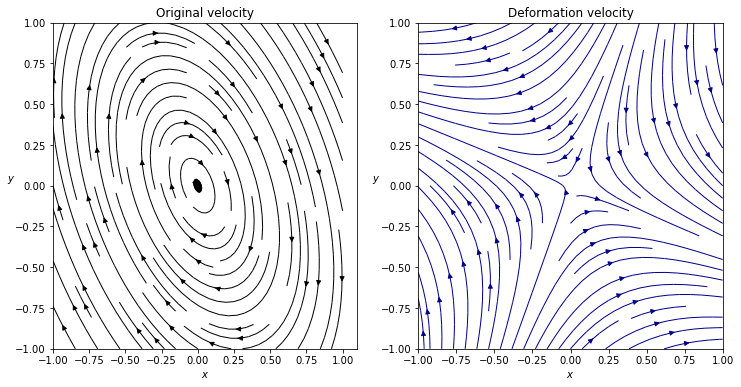

In [129]:
import numpy as np
import matplotlib.pyplot as plt
timeslice = 10
# we select an arbitrary time instant
size = 1
# domain size 


fig = plt.figure(figsize= (12, 6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


[X,Y] = np.meshgrid(np.linspace(-size, size, 100), np.linspace(-size, size, 100))

### Left figure is the original field

ax.streamplot(X, Y, vOriginalX_numeric(timeslice, X, Y), vOriginalY_numeric(timeslice, X, Y), density=0.9, color='k', linewidth=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0)
ax.set_title('Original velocity')



### upper right is alpha =0, [-1,1]
ax2.streamplot(X, Y, vDefX_numeric(timeslice, X, Y), vDefY_numeric(timeslice, X, Y), density=0.9, color='darkblue', linewidth=1)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$', rotation=0)
ax2.set_title('Deformation velocity')






Same calculation with $a=30$

Text(0.5, 1.0, 'Deformation velocity')

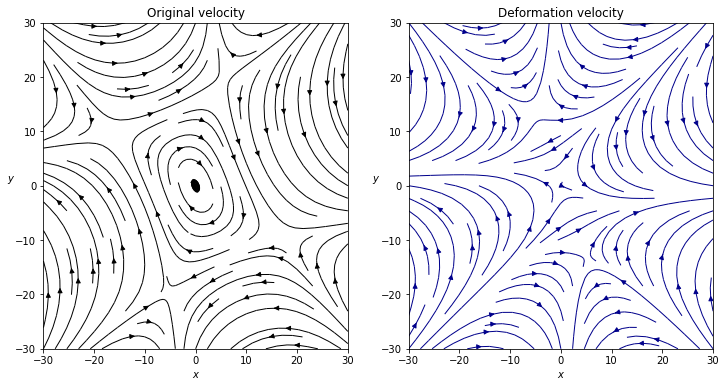

In [130]:
import numpy as np
import matplotlib.pyplot as plt
timeslice = 10
# we select an arbitrary time instant
size = 30
# domain size 


fig = plt.figure(figsize= (12, 6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


[X,Y] = np.meshgrid(np.linspace(-size, size, 100), np.linspace(-size, size, 100))

### Left figure is the original field

ax.streamplot(X, Y, vOriginalX_numeric(timeslice, X, Y), vOriginalY_numeric(timeslice, X, Y), density=0.9, color='k', linewidth=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0)
ax.set_title('Original velocity')



### upper right is alpha =0, [-1,1]
ax2.streamplot(X, Y, vDefX_numeric(timeslice, X, Y), vDefY_numeric(timeslice, X, Y), density=0.9, color='darkblue', linewidth=1)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$', rotation=0)
ax2.set_title('Deformation velocity')






## Ocean surface velocity field


We will use geostrophic velocities measured in the Gulf Stream region. More details about the dataset can be found in the following [notebook](ProcessOceanData.ipynb), where we have exported the required variables to text files. 

The geostrophic velocity's zonal component is denoted by $u(x,y)$ while the meridian component is $v(x,y)$.

$$
\frac{d}{dt}\begin{pmatrix}x \\ y\end{pmatrix} = \begin{pmatrix}u(x,y) \\ v(x,y) \end{pmatrix}
$$

The horizontal variable $x$ is the longitude and the vertical variable $y$ is the latitude. 

In [55]:
import numpy as np


# load the text files containing u, v, h, longitudes and latitudes
US = np.loadtxt('data/Us.dat')
VS = np.loadtxt('data/Vs.dat')
H = np.loadtxt('data/SSH.dat')

lons = np.loadtxt('data/lon.dat')
lats = np.loadtxt('data/lat.dat')



Originally the full domain is 

$$
(x,y) \in [280.125, 332.875] \times [32.125, 47.875],
$$

in the following we will use smaller subdomains of this. 

In [69]:

def selectRegion(Fun, X, Y, xdom, ydom):
    xmin, xmax = xdom
    ymin, ymax = ydom
    xdomain = np.logical_and(X <= xmax, X >= xmin)
    ydomain = np.logical_and(Y <= ymax, Y >= ymin)
    selectedX = Fun[:, xdomain]
    
    return X[xdomain], Y[ydomain], selectedX[ydomain, :]


In [153]:

# We will use the symbolic calculation for the moment of inertia tensor. 
# That is compatible with numeric domains as well


def angularMomentum2D_data(U, V, X, Y): 
    Xrel, Yrel = np.meshgrid(X - np.average(X), Y -np.average(Y)) # relative coordinates
    
    VecOfPositions = np.array([Xrel.ravel(), Yrel.ravel()]).T 
    VecOfVelocities = np.array([(U - np.average(U)).ravel(), (V - np.average(V)).ravel()]).T
    return np.average(np.cross(VecOfPositions, VecOfVelocities))

def calculateOmega_data(inertiatensor, angularmomentum):
    return np.array(inertiatensor.inv(), dtype='float') @ np.array([0,0,angularmomentum]) # need to create a temporary 3D vector, because the angular momentum is a scalar


def relativeVelocity2D_data(U, V, X, Y, omega):
    xmax = np.max(X)
    xmin = np.min(X)
    ymax = np.max(Y)
    ymin = np.min(Y)
    
    x0 = np.mean([xmin, xmax])
    y0 = np.mean([ymin, ymax]) # calculate the center of mass
    XX, YY = np.meshgrid(X - x0, Y - y0)

    Ubody = np.average(U) - omega * YY
    Vbody = np.average(V) + omega * XX
    return U-Ubody, V - Vbody





### $U_0$, larger domain


First, let us consider the domain

$$
U_0 =  [290, 310] \times [33.2, 41].
$$


In [154]:
U0domain = [[290, 310], [33.2, 41]]
xx_0, yy_0, Hcut_0 = selectRegion(H, lons, lats, *U0domain)
xx_0, yy_0, Ucut_0 = selectRegion(US, lons, lats, *U0domain)
xh_0, yy_0, Vcut_0 = selectRegion(VS, lons, lats, *U0domain)

In [155]:
import matplotlib.pyplot as plt

(33.3, 41.0)

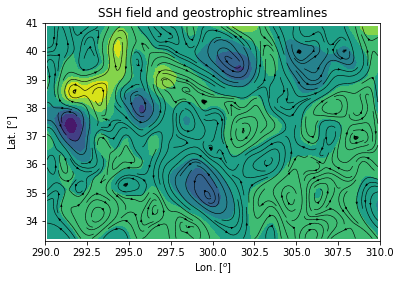

In [156]:
plt.contourf(xx_0, yy_0, Hcut_0)
plt.title('SSH field and geostrophic streamlines')
plt.streamplot(xx_0, yy_0, Ucut_0, Vcut_0, density=2, linewidth=0.6, arrowsize=0.4, color='black')
plt.xlabel('Lon. $[^o]$')
plt.ylabel('Lat. $[^o]$')
plt.xlim(290, 310)
plt.ylim(33.3, 41)


As suggested by the sea surface height field, this domain contains multiple mesoscale eddies. This means that we can't hope to find a single, well-fitting rigid body motion that serves as a good co-moving frame for the fluid.



In [143]:
I_0 = InertiaTensor(*U0domain)
L_0 = angularMomentum2D_data(Ucut_0, Vcut_0, xx_0, yy_0)
omega_0 = calculateOmega_data(I_0, L_0)
disp('\\boldsymbol{\omega}_z',omega_0[2])


We get a small negative value for the rigid-body angular velocity.

In [145]:
Urel_0, Vrel_0 = relativeVelocity2D_data(Ucut_0, Vcut_0, xx_0, yy_0, omega_0[2]) # must supply only the z component 



(33.3, 41.0)

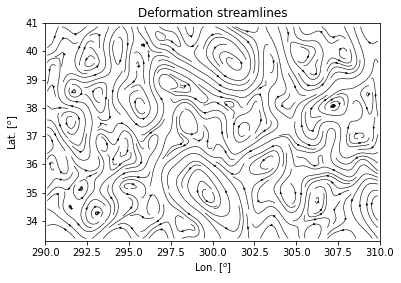

In [148]:
plt.title('Deformation streamlines')
plt.streamplot(xx_0, yy_0, Urel_0, Vrel_0, density=2, linewidth=0.6, arrowsize=0.4, color='black')
plt.xlabel('Lon. $[^o]$')
plt.ylabel('Lat. $[^o]$')
plt.xlim(290, 310)
plt.ylim(33.3, 41)


### $U_1$, smaller domain



$$
U_1 =  [290.2, 293] \times [36., 38.6].
$$


In [159]:
U1domain = [[290.2, 293], [36, 38.6]]
xx_1, yy_1, Hcut_1 = selectRegion(H, lons, lats, *U1domain)
xx_1, yy_1, Ucut_1 = selectRegion(US, lons, lats, *U1domain)
xh_1, yy_1, Vcut_1 = selectRegion(VS, lons, lats, *U1domain)

In [163]:
I_1 = InertiaTensor(*U1domain)
L_1 = angularMomentum2D_data(Ucut_1, Vcut_1, xx_1, yy_1)
omega_1 = calculateOmega_data(I_1, L_1)
disp('\\boldsymbol{\omega}_z',omega_1[2])
Urel_1, Vrel_1 = relativeVelocity2D_data(Ucut_1, Vcut_1, xx_1, yy_1, omega_1[2]) # must supply only the z component 


(36.0, 38.6)

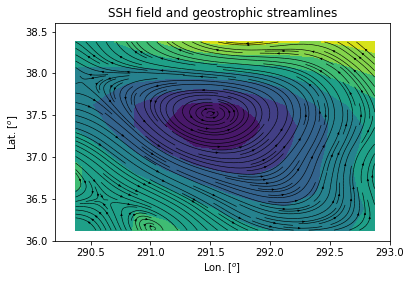

In [162]:
plt.contourf(xx_1, yy_1, Hcut_1)
plt.title('SSH field and geostrophic streamlines')
plt.streamplot(xx_1, yy_1, Ucut_1, Vcut_1, density=2, linewidth=0.6, arrowsize=0.4, color='black')
plt.xlabel('Lon. $[^o]$')
plt.ylabel('Lat. $[^o]$')
plt.xlim(*U1domain[0])
plt.ylim(*U1domain[1])


(36.0, 38.6)

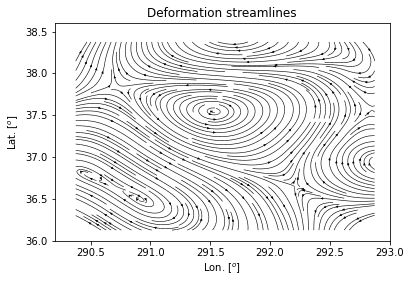

In [168]:
#plt.contourf(xx_1, yy_1, Hcut_1)
plt.title('Deformation streamlines')

plt.streamplot(xx_1, yy_1, Urel_1, Vrel_1, density=2, linewidth=0.6, arrowsize=0.4, color='black')
plt.xlabel('Lon. $[^o]$')
plt.ylabel('Lat. $[^o]$')
plt.xlim(*U1domain[0])
plt.ylim(*U1domain[1])
